In [908]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm

sns.set_style('dark')


import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch import optim

from torchvision import transforms

In [909]:
data_path = os.path.join('.', 'data')

train_path = os.path.join(data_path, 'train', 'train')
val_path = os.path.join(data_path, 'validation')
test_path = os.path.join(data_path, 'test', 'test')

In [910]:
def show_images(ct,dose,possible_dose_mask,structure_masks,sample_idx=0,**kwargs):

        structure_masks = structure_masks.squeeze(0)
        fig, ax = plt.subplots(2, 2)
        ax = ax.flatten()
        ax[0].imshow(ct.squeeze(), cmap='gray', vmin=0, vmax=ct.max())
        ax[0].set_title('CT')
        ax[1].imshow(dose.squeeze())
        ax[1].set_title('Dose')
        ax[2].imshow(possible_dose_mask.squeeze())
        ax[2].set_title('Possible dose mask')
        for organ in structure_masks:
            ax[3].imshow(organ)
        ax[3].set_title('Structure masks')

        for axis in ax:
            axis.axis('off')

        plt.tight_layout()
        plt.suptitle('Sample '+str(sample_idx))
        plt.show()

In [911]:
def show_random_images(path,n):
    id_exs = np.random.randint(0, 7799,n)
    for id_ex in id_exs:
        sample_path = os.path.join(path, 'sample_'+str(id_ex))
        ct_path = os.path.join(sample_path, 'ct.npy')
        dose_path = os.path.join(sample_path, 'dose.npy')
        possible_dose_mask_path = os.path.join(sample_path, 'possible_dose_mask.npy')
        structure_masks_path = os.path.join(sample_path, 'structure_masks.npy')

        ct = torch.from_numpy(np.load(ct_path)).unsqueeze(0)
        dose = torch.from_numpy(np.load(dose_path)).unsqueeze(0)
        possible_dose_mask = torch.from_numpy(np.load(possible_dose_mask_path)).unsqueeze(0)
        structure_masks = torch.from_numpy(np.load(structure_masks_path)).unsqueeze(0)
        

        show_images(ct,dose,possible_dose_mask,structure_masks,sample_idx=id_ex)

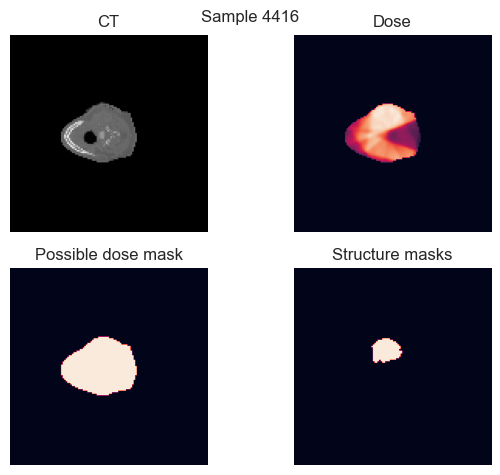

In [912]:
show_random_images(train_path, 1)

In [913]:
#Manual load of a sample
id_ex = 0
sample_path = os.path.join(train_path, 'sample_'+str(id_ex))
ct_path = os.path.join(sample_path, 'ct.npy')
dose_path = os.path.join(sample_path, 'dose.npy')
possible_dose_mask_path = os.path.join(sample_path, 'possible_dose_mask.npy')
structure_masks_path = os.path.join(sample_path, 'structure_masks.npy')

ct = torch.from_numpy(np.load(ct_path)).unsqueeze(0)
dose = torch.from_numpy(np.load(dose_path)).unsqueeze(0)
possible_dose_mask = torch.from_numpy(np.load(possible_dose_mask_path)).unsqueeze(0)
structure_masks = torch.from_numpy(np.load(structure_masks_path))


# Dataset

In [914]:
class DLMI_train(Dataset):
    '''Dataset for the DLMI challenge
    
    Parameters
    ----------
    path : str
        Path to the dataset
    ct_transform : torchvision.transforms
        Transform to apply to the CT image
    dose_transform : torchvision.transforms
        Transform to apply to the dose image
    aug_transform : list of transformations
        List of augmentations to apply to all the images

    Returns
    -------
    x : torch.Tensor
        (12,128,128) tensor containing the CT, possible_dose_mask and structure_masks
    sample_idx : int
        Index of the sample
    y : torch.Tensor 
        (1,128,128) tensor containing the dose
    '''
    def __init__(self, path,ct_transform = None, dose_transform = None,aug_transform = []):
        self.path = path
        self.samples = os.listdir(path)
        self.ct_transform = ct_transform
        self.dose_transform = dose_transform
        
        assert isinstance(aug_transform, list) , 'aug_transform must be a list'

        self.aug_transform = aug_transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample_path = os.path.join(self.path, self.samples[idx])
        ct_path = os.path.join(sample_path, 'ct.npy')
        dose_path = os.path.join(sample_path, 'dose.npy')
        possible_dose_mask_path = os.path.join(sample_path, 'possible_dose_mask.npy')
        structure_masks_path = os.path.join(sample_path, 'structure_masks.npy')

        ct = torch.from_numpy(np.load(ct_path)).unsqueeze(0)
        dose = torch.from_numpy(np.load(dose_path)).unsqueeze(0)
        possible_dose_mask = torch.from_numpy(np.load(possible_dose_mask_path)).unsqueeze(0)
        structure_masks = torch.from_numpy(np.load(structure_masks_path))
        
        if self.ct_transform:
            ct = self.ct_transform(ct)
        if self.dose_transform:
            dose = self.dose_transform(dose)
        if self.aug_transform:
            for aug in self.aug_transform:
                aug.update_params()
                ct = aug(ct)
                dose = aug(dose)
                possible_dose_mask = aug(possible_dose_mask)
                structure_masks = aug(structure_masks)
        # if self.aug_transform:
        #     ct, dose, possible_dose_mask, structure_masks = self.aug_transform(ct, dose, possible_dose_mask, structure_masks)

        #Stack the images
        x = torch.cat((ct, possible_dose_mask, structure_masks), dim=0)

        #Keep only the last digits, ie get rid of the 'sample_' part
        sample_idx = int(self.samples[idx].split('_')[-1])
        return x, dose, sample_idx

In [915]:
class DLMI_test(Dataset):
    '''Dataset for the DLMI challenge

    Parameters
    ----------
    path : str
        Path to the dataset
    ct_transform : torchvision.transforms
        Transform to apply to the CT image

    Returns
    -------
    x : torch.Tensor
        (12,128,128) tensor containing the CT, possible_dose_mask and structure_masks
    idx : int
        Index of the sample
    '''

    def __init__(self, path,ct_transform = None):
        self.path = path
        self.samples = os.listdir(path)
        self.ct_transform = ct_transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample_path = os.path.join(self.path, self.samples[idx])
        ct_path = os.path.join(sample_path, 'ct.npy')
        possible_dose_mask_path = os.path.join(sample_path, 'possible_dose_mask.npy')
        structure_masks_path = os.path.join(sample_path, 'structure_masks.npy')

        ct = torch.from_numpy(np.load(ct_path)).unsqueeze(0)
        possible_dose_mask = torch.from_numpy(np.load(possible_dose_mask_path)).unsqueeze(0)
        structure_masks = torch.from_numpy(np.load(structure_masks_path))
        
        if self.ct_transform:
            ct = self.ct_transform(ct)

        #Stack the images
        x = torch.cat((ct, possible_dose_mask, structure_masks), dim=0)
        sample_idx = int(self.samples[idx].split('_')[-1])
        return x, sample_idx

In [916]:
class RandomRotationOneShot():
    def __init__(self, angle, p=0.5):	
        self.angle = angle
        self.p = p
        self.rotate = None
        self.rotate_angle = None

    def __call__(self, x):
        if self.rotate:
            x = transforms.functional.rotate(x, self.rotate_angle)
        return x

    def update_params(self):
        self.rotate = np.random.uniform() < self.p
        self.rotate_angle = np.random.uniform(-self.angle, self.angle)

class RandomHorizontalFlipOneShot():
    def __init__(self, p=0.5):
        self.p = p
        self.flip = None

    def __call__(self, x):
        if self.flip:
            x = transforms.functional.hflip(x)
        return x

    def update_params(self):
        self.flip = np.random.uniform() < self.p

class RandomVerticalFlipOneShot():
    def __init__(self, p=0.5):
        self.p = p
        self.flip = None

    def __call__(self, x):
        if self.flip:
            x = transforms.functional.vflip(x)
        return x

    def update_params(self):
        self.flip = np.random.uniform() < self.p

In [917]:
mean_ct = np.load(os.path.join(data_path, 'mean_ct.npy'))
std_ct = np.load(os.path.join(data_path, 'std_ct.npy'))
mean_dose = np.load(os.path.join(data_path, 'mean_dose.npy'))
std_dose = np.load(os.path.join(data_path, 'std_dose.npy'))

In [918]:
ct_transform = transforms.Compose([transforms.Normalize(mean_ct, std_ct)])
dose_transform = transforms.Compose([transforms.Normalize(mean_dose, std_dose)])
# aug_transform = transforms.Compose([transforms.RandomHorizontalFlip(p=0.5),
#                                     transforms.RandomVerticalFlip(p=0.5),
#                                     transforms.RandomRotation(90, fill=(0,)),
#                                     ])
aug_transform = [RandomHorizontalFlipOneShot(p=0.5),
                 RandomVerticalFlipOneShot(p=0.5),
                 RandomRotationOneShot(90, p=0.5),]

test_transform = transforms.Compose([transforms.Normalize(mean_ct, std_ct)])

In [919]:
def compute_mean_std(loader):
    mean_ct = 0.
    std_ct = 0.

    mean_dose = 0.
    std_dose = 0.
    nb_samples = 0.

    for (ct, _, _), dose in tqdm(loader):
        batch_samples = ct.size(0)

        ct = ct.view(batch_samples, ct.size(1), -1)
        dose = dose.view(batch_samples, dose.size(1), -1)

        mean_ct += ct.mean((1,2)).sum(0)
        std_ct += ct.std((1,2)).sum(0)

        mean_dose += dose.mean((1,2)).sum(0)
        std_dose += dose.std((1,2)).sum(0)

        nb_samples += batch_samples

    mean_ct /= nb_samples
    std_ct /= nb_samples

    mean_dose /= nb_samples
    std_dose /= nb_samples

    print(f"{mean_ct=}, {std_ct=}, {mean_dose=}, {std_dose=}")
    return mean_ct, std_ct, mean_dose, std_dose

In [920]:
# mean_ct, std_ct, mean_dose, std_dose = compute_mean_std(train_loader)
# # Save these values
# data_path = os.path.join('.', 'data')
# np.save(os.path.join(data_path, 'mean_ct.npy'), mean_ct)
# np.save(os.path.join(data_path, 'std_ct.npy'), std_ct)
# np.save(os.path.join(data_path, 'mean_dose.npy'), mean_dose)
# np.save(os.path.join(data_path, 'std_dose.npy'), std_dose)

# Architecture

Unet architecture. 

As post processing, we should intersect the predicted mask with the mask image.

In [921]:
from Unet import UNet
from torchinfo import summary

# Training and testing functions

In [922]:
def train_one_epoch(model, optimizer, criterion, train_loader, device):
    model.train()

    train_loss = 0
    batches_seen = 0
    pbar = tqdm(train_loader)

    for batch_idx,(x, dose,_) in enumerate(pbar):
        x = x.to(device).float()
        dose = dose.to(device).float()

        optimizer.zero_grad()

        output = model(x)
        loss = criterion(output, dose)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        batches_seen += 1

        pbar.set_postfix_str(f"train_loss: {train_loss/batches_seen:.4f}")

    return train_loss/batches_seen

In [923]:
def validate_one_epoch(model, criterion, val_loader, device):
    model.eval()

    test_loss = 0
    pbar = tqdm(val_loader)
    batches_seen = 0

    with torch.no_grad():
        for batch_idx,(x, dose,_) in enumerate(pbar):
            x = x.to(device).float()
            dose = dose.to(device).float()

            output = model(x)
            loss = criterion(output, dose)

            test_loss += loss.item()
            batches_seen += 1

            pbar.set_postfix_str(f"val_loss: {test_loss/batches_seen:.4f}")

    return test_loss/batches_seen

In [924]:
def post_process(possible_dose_mask, dose):
    ''' 
    Post processing of the dose prediction. Given the possible dose mask and the dose prediction, we intersect the two

    Parameters
    ----------
    possible_dose_mask : torch.Tensor
        The possible dose mask. Shape (batch_size, 1, 128, 128)
    dose : torch.Tensor
        The dose prediction. Shape (batch_size, 1, 128, 128)
    '''

    return possible_dose_mask * dose

In [925]:
def test_model(model,test_loader,device):

    df = pd.DataFrame(columns=['Id', 'Expected'])
    model.eval()

    pbar = tqdm(test_loader)
    batches_seen = 0
    mae_loss = 0

    with torch.no_grad():
        for batch_idx,(x, dose,sample_idx) in enumerate(pbar):
            x = x.to(device).float()
            dose = dose.to(device).float()
            possible_dose_mask = x[:, 1, :, :].unsqueeze(1)

            output = model(x)
            output = post_process(possible_dose_mask, output)
            # In order to have the MAE loss, we need to flatten the output and the dose
            output = output.view(output.size(0), -1)
            dose = dose.view(dose.size(0), -1)

            loss = nn.L1Loss(reduction='none')(output, dose)
            loss_per_sample = loss.mean(1).detach().cpu().numpy()

            df_batch = pd.DataFrame({'Id': list(sample_idx), 'Expected': list(loss_per_sample)})
            df = pd.concat([df, df_batch], axis=0)

            mae_loss += loss_per_sample.mean()
            batches_seen += 1

            pbar.set_postfix_str(f"avg loss: {mae_loss/batches_seen:.4f},batch loss: {loss_per_sample.mean():.4f}")

    mae_loss /= batches_seen
    return mae_loss, df

# Setting of the training

In [926]:
num_workers = 0
lr = 1e-3
batch_size = 16
num_epochs = 100
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
exp_dir = os.path.join('.', 'exp')
os.makedirs(exp_dir, exist_ok=True)

In [927]:
train_dataset = DLMI_train(train_path, ct_transform, dose_transform, aug_transform)
val_dataset = DLMI_train(val_path, ct_transform, dose_transform)
test_dataset = DLMI_test(test_path, test_transform)

In [942]:
print(f"Train dataset size: {len(train_dataset)}")
print(f"Val dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Train dataset size: 7800
Val dataset size: 1200
Test dataset size: 1200


In [928]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [929]:
model = UNet( n_channels=12, n_classes=1)

In [930]:
# col_names = ['input_size', 'output_size', 'num_params']
# summary(model, input_size=(1,12, 128, 128), device='cpu', col_names=col_names, col_width=20)

In [931]:
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.L1Loss() # Mean Absolute Error

In [932]:
model = model.to(device)

In [933]:
# train_one_epoch(model, optimizer, criterion, train_loader, "cuda")
# torch.save(model.state_dict(), 'model.pth')

In [934]:
os.makedirs(exp_dir, exist_ok=True)
state = dict(
    epoch= 1,
    model=model.state_dict(),
    optimizer=optimizer.state_dict(),
)
save_path = os.path.join(exp_dir, 'model.pth')
torch.save(state, save_path)

# Load model

In [935]:
load_path = os.path.join(exp_dir, 'model.pth')
ckpt = torch.load(load_path, map_location="cpu")
start_epoch = ckpt["epoch"]
model.load_state_dict(ckpt["model"])
model = model.to(device)
optimizer.load_state_dict(ckpt["optimizer"])

In [936]:
#Make a prediction on the train/val set
def predict(model, loader, device,n_preds=1):
    ''' Predicts the output of the model on the given dataset loader
    
    Parameters
    ----------
    model : torch.nn.Module
        The model to predict on
    loader : torch.utils.data.DataLoader
        The dataloader containing the dataset to predict on
    device : torch.device
        The device to run the model on
    n_preds : int
        The number of batches to go through. Default is 1

    Returns
    -------
    input : np.ndarray
        The input to the model. Shape (n_preds*batch_size, 12, 128, 128)
    preds : np.ndarray
        The predictions of the model. Shape (n_preds*batch_size, 1, 128, 128)
    ground_truth : np.ndarray
        The ground truth of the model. Shape (n_preds*batch_size, 1, 128, 128)
    '''
    model.eval()

    with torch.no_grad():
        seen = 0
        pbar = tqdm(loader, total=n_preds)
        for batch_idx,(x,y,idx) in enumerate(pbar):
            x = x.to(device).float()

            output = model(x)
            output = output.cpu().numpy()

            if batch_idx == 0:
                input = x.cpu().numpy()
                preds = output
                ground_truth = y.numpy()
            else:
                preds = np.concatenate((preds, output), axis=0)
                ground_truth = np.concatenate((ground_truth, y.numpy()), axis=0)
                input = np.concatenate((input, x.cpu().numpy()), axis=0)

            seen += 1

            if seen >= n_preds:
                # Set the pbdar to 100% to make sure it is done
                print("Done")
                break

    return input,preds, ground_truth

In [937]:
input,preds,ground_truth = predict(model, train_loader, "cuda", n_preds=1)

  0%|          | 0/1 [00:00<?, ?it/s]

Done


In [938]:
# nb_to_show = np.min([preds.shape[0], 4])

# rand_idx = np.random.choice(np.arange(preds.shape[0]), nb_to_show, replace=False)

# for i in rand_idx:
#     pred_model = preds[i].squeeze()
#     gt = ground_truth[i].squeeze()
#     possible_dose_mask = input[i,1].squeeze()

#     pred = np.where(possible_dose_mask, pred_model, 0)

#     mae = np.mean(np.abs(pred - gt))

#     fig, ax = plt.subplots(1,3, figsize=(10,5))
#     ax[0].imshow(pred)
#     ax[0].set_title("Prediction")
#     ax[1].imshow(gt)
#     ax[1].set_title("Ground Truth")
#     ax[2].imshow(possible_dose_mask)
#     ax[2].set_title("Possible Dose Mask")
#     plt.suptitle(f"MAE: {mae:.4f}")
#     plt.show()


In [940]:
mae_loss, df = test_model(model, val_loader, "cuda")

100%|██████████| 75/75 [00:12<00:00,  5.84it/s, avg loss: 0.5016,batch loss: 0.4425]


In [944]:
mae_loss

0.5015677440166474